# Play with 3d output 


In [14]:
# load modules 

import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline

In [16]:
data_dir = '/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored/'

model_vars = ['T','U','V','W','PTRACER01'] 

diter = int(3*24*3600/300)
iters = range(17574624, 17574624+10*diter, diter)

ds_model = open_mdsdataset(data_dir , delta_t=300, iters=iters,  
                          prefix=model_vars,
                          ignore_unknown_vars=True, geometry='cartesian')

In [17]:
ds_model

<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 10)
Coordinates:
  * XC                   (XC) >f4 2500.0 7500.0 12500.0 ... 1992500.0 1997500.0
  * YC                   (YC) >f4 2500.0 7500.0 12500.0 ... 1992500.0 1997500.0
  * XG                   (XG) >f4 0.0 5000.0 10000.0 ... 1990000.0 1995000.0
  * YG                   (YG) >f4 0.0 5000.0 10000.0 ... 1990000.0 1995000.0
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 ... -2727.5 -2830.5 -2933.5
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 ... -2779.0 -2882.0 -2985.0
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 ... -2676.0 -2779.0 -2882.0
    rA                   (YC, XC) >f4 dask.array<shape=(400, 400), chunksize=(400, 400)>
    dxG                  (YG, XC) >f4 dask.array<shape=(400, 400), chunksize=(4

### Use this data to compute the tracer variance budgets 

\begin{equation}
\partial_t (\overline{c'^2}/2) + \nabla. (\overline{\mathbf{v}c'^2})/2 = diss  - \overline{\mathbf{v}'c'}.\nabla \overline{c}
\end{equation}

In [19]:
from xgcm import Grid

grid = Grid(ds_model, periodic='X')

In [29]:
dx = ds_model.dxC[0,0]

In [35]:
# tracer eddy terms
tracer = 'T'
cbar = ds_model[tracer].mean('time')
cp = ds_model[tracer] - cbar 
phi = (cp*cp).mean('time')

In [20]:
# velocity eddy terms
ubar = ds_model['U'].mean('time')
vbar = ds_model['V'].mean('time')
wbar = ds_model['W'].mean('time')

up = ds_model['U'] - ubar
vp = ds_model['V'] - vbar
wp = ds_model['W'] - wbar

In [23]:
# tracer fluxes 
upcp = (grid.interp(up, 'X') * cp).mean('time')
vpcp = (grid.interp(vp, 'Y', boundary='extend') * cp).mean('time')
wpcp = (grid.interp(wp, 'Z', boundary='extend') * cp).mean('time')

In [28]:
# var transport by mean
ubarcpcp = (grid.interp(ubar, 'X') * cp * cp).mean('time')
vbarcpcp = (grid.interp(vbar, 'Y', boundary='extend') * cp * cp).mean('time')
wbarcpcp = (grid.interp(wbar, 'Z', boundary='extend') * cp * cp).mean('time')

In [41]:
# divergence of above term 
divmeanvartransport = ( grid.interp(grid.diff(ubarcpcp, 'X')/dx, 'X') + 
                        grid.interp(grid.diff(vbarcpcp, 'Y', boundary='extend')/dx, 'Y', boundary='extend') -
                        grid.interp(grid.diff(wbarcpcp, 'Z', boundary='extend'), 'Z', boundary='extend')/ ds_model.drF) 

In [27]:
# var transport by eddy
upcpcp = (grid.interp(up, 'X') * cp * cp).mean('time')
vpcpcp = (grid.interp(vp, 'Y', boundary='extend') * cp * cp).mean('time')
wpcpcp = (grid.interp(wp, 'Z', boundary='extend') * cp * cp).mean('time')

In [42]:
# divergence of above term 
diveddyvartransport = ( grid.interp(grid.diff(upcpcp, 'X')/dx, 'X') + 
                        grid.interp(grid.diff(vpcpcp, 'Y', boundary='extend')/dx, 'Y', boundary='extend') -
                        grid.interp(grid.diff(wpcpcp, 'Z', boundary='extend'), 'Z', boundary='extend')/ ds_model.drF) 

In [33]:
# flux projection on mean grad 
# the interpolation can be reduced by not having brought to the fluxes to center point early on
Fgradcbar = ( upcp * grid.interp(grid.diff(cbar, 'X')/dx,'X') + 
              vpcp * grid.interp(grid.diff(cbar, 'Y', boundary='extend')/dx, 'Y', boundary='extend')  
             -wpcp * grid.interp(grid.diff(cbar, 'Z', boundary='extend'), 'Z', boundary='extend')/ds_model.drF)

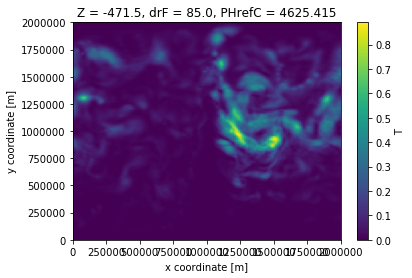

In [37]:
phi.sel(Z=-500, method='nearest').plot()

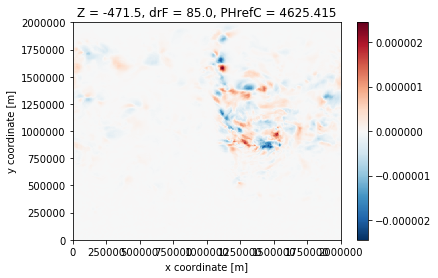

In [39]:
Fgradcbar.sel(Z=-500, method='nearest').plot()

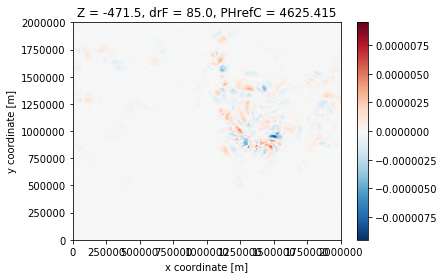

In [43]:
divmeanvartransport.sel(Z=-500, method='nearest').plot()

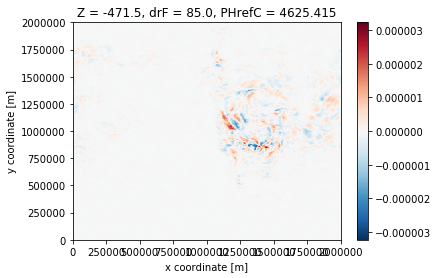

In [44]:
diveddyvartransport.sel(Z=-500, method='nearest').plot()